# Command Recognition using keywords

## 1. Import Dependencies

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers, losses, optimizers
from IPython import display

### 1.1 Global Variables

In [2]:
SAMPLING_RATE = 16000 #16 kHz
DATASET_PATH = 'Data\mini_speech_commands'
SEED = 128 # A seed can be used to reproduce results // Original Value: 128
EXAMPLE_WAV = [] # Holds a batch of wav file data
EXAMPLE_FFT = [] # Holds a batch of FFT transformed data
EXAMPLE_STFT = [] # Holds a batch of STFT transformed data


### 1.2 Setting a seed

In [3]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

## 2. Load the Dataset

In [4]:
data_dir = pathlib.Path(DATASET_PATH) # Converts string to file path based on OS

# Creates the directroy and downloads dataset if not made yet
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='Data')

Splits dataset into batches of audio clips with their respective integer labels

In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3, # 30% used as validation/test set, will be split again later
    seed=SEED,
    output_sequence_length=16000, # Keeps all audio clips at one second
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 5600 files for training.
Using 2400 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Note the labels are integers and not one hot encoded vectors. The sparse categorical cross entropy loss function part of the keras library will automatically convert integer labels to one hot encoded vectors during training and evaluation

In [6]:
for example_audio, example_labels in train_ds.take(1):
  pass

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = tf.squeeze(example_audio[i], axis=-1)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=SAMPLING_RATE))

Label: yes
Waveform shape: (16000,)
Audio playback


Label: down
Waveform shape: (16000,)
Audio playback


Label: right
Waveform shape: (16000,)
Audio playback


## 3. Model 1: Waveform Model

### 3.1 Preprocessing the Data

Audio clips are in the shape of (Batch, Samples, Channels). Since there is only one channel, the channel dimension is redundant and can be eliminated

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Using tf.data.AUTOTUNE as a parameter for num_parallel_calls to dynamically adjust processing based on CPU/GPU usage
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Showing the shape of each batch

In [8]:
# 64 files each 16000 samples long per batch
for example_audio, example_labels in train_ds.take(1):
  EXAMPLE_WAV = example_audio
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Split the Validation set into a seperate validation and test set, both comprising of 15% of the total dataset

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Plots waveforms of first n samples of training data

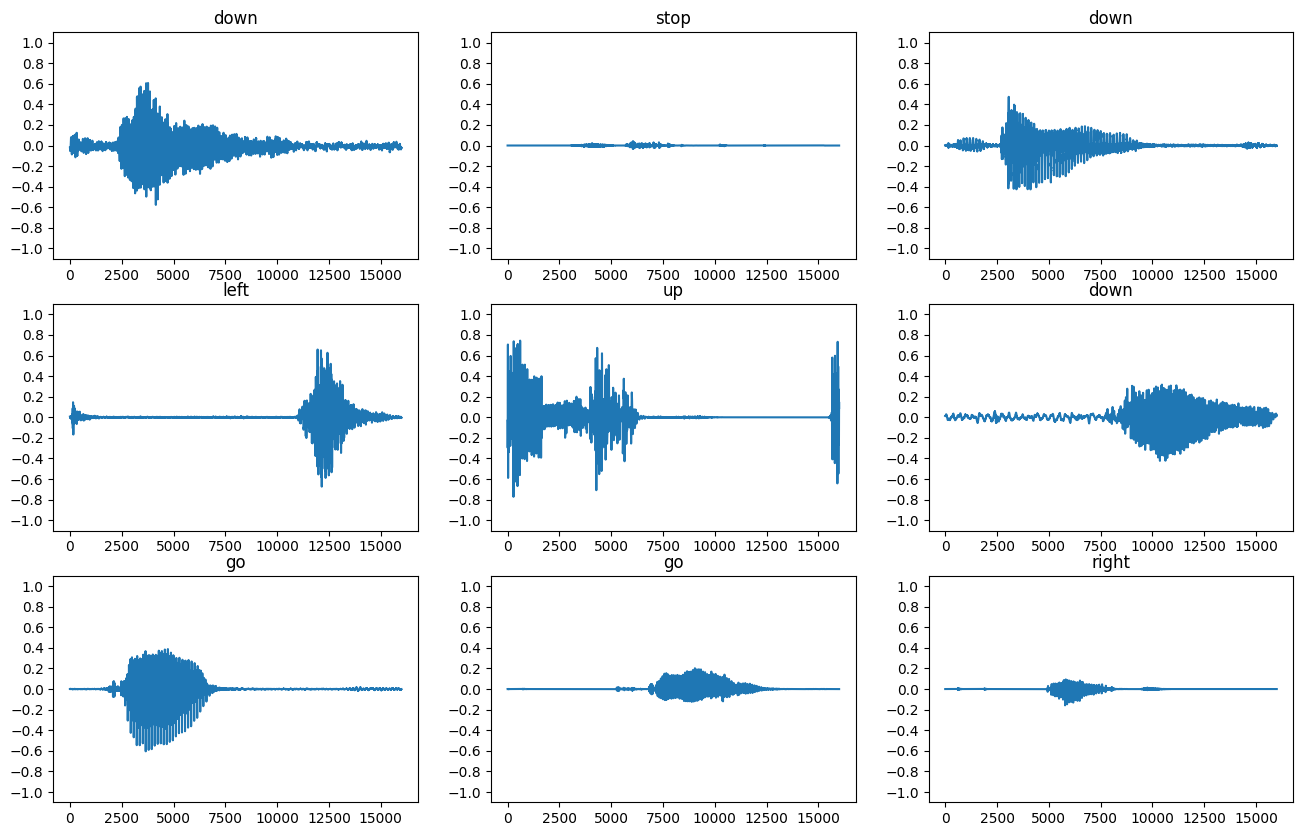

In [10]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

### 3.2 Building the Model

For this model I am going to use a dense nueral network since it they work well for classification tasks and can learn underlying relationships in higher dimentional data

#### Loading the data

Adding cache and prefetch operations to the datasets reduces read latency when pulling data to feed to the models

In [11]:
train_ds = train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

#### Trial 1

In [12]:
input_shape = EXAMPLE_WAV[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_ds.map(lambda wav, labels: wav)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    norm_layer,
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(output_shape)
], name='Wav_Model_1')

model.summary()

Model: "Wav_Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 16000)          │        32,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,096,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,168,011 (15.90 MB)

 Trainable params: 4,136,010 (15.78 MB)

 Non-trainable params: 32,001 (125.01 KB)

In [13]:
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
epochs = 20

fit_data = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), # Comment out for testing and analysis
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.1279 - loss: 2.3716 - val_accuracy: 0.1284 - val_loss: 2.1975
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.2380 - loss: 2.0872 - val_accuracy: 0.1529 - val_loss: 2.1642
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3144 - loss: 1.9653 - val_accuracy: 0.1301 - val_loss: 2.2199
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4081 - loss: 1.7509 - val_accuracy: 0.1461 - val_loss: 2.3492
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4944 - loss: 1.5483 - val_accuracy: 0.1318 - val_loss: 2.3623
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5525 - loss: 1.3810 - val_accuracy: 0.1318 - val_loss: 2.5717
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6083 - loss: 1.3077 - val_accuracy: 0.1334 - val_loss: 2.6273
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6483 - loss: 1.1705 - val_accuracy: 0.1343 - v

#### Trial 1 Results

Text(0, 0.5, 'Accuracy [%]')

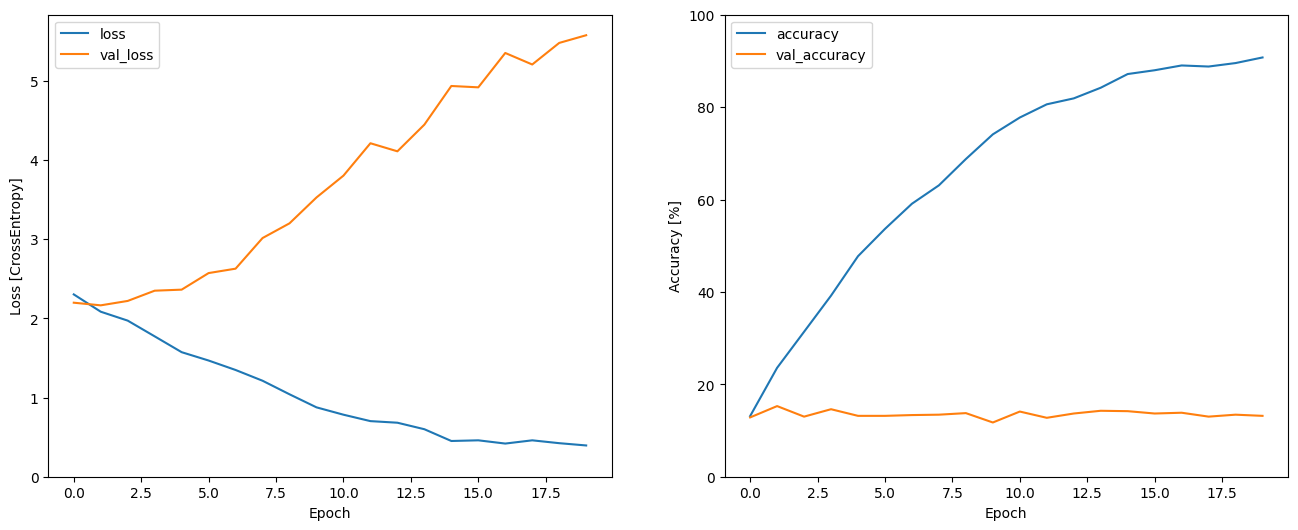

In [15]:
metrics = fit_data.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(fit_data.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(fit_data.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Trial 1 Discussion

This model does not seem to be learning any underlying patterns at all, the validation loss and accuracy were nearly constant and the training metrics barely improved over 20 epochs. Juding by the accuracy, it seems like it is randomly guessing the classes of the validation set. It is surprising because I initially thought there were some observed similarities in the waveforms of words within the same category. The model just seems to be learning the training data and overfits heavily. 

#### Further Tuning

In [16]:
input_shape = EXAMPLE_WAV[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_ds.map(lambda wav, labels: wav)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    norm_layer,
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    #layers.Dropout(0.2),
    layers.Dense(output_shape)
], name='Wav_Model_2')

model.summary()

model.compile(
    optimizer=optimizers.Nadam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 20

fit_data = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), # Comment out for testing and analysis
)

Model: "Wav_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 16000)          │        32,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     8,192,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,298,953 (31.66 MB)

 Trainable params: 8,266,952 (31.54 MB)

 Non-trainable params: 32,001 (125.01 KB)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.1237 - loss: 26.9626 - val_accuracy: 0.1106 - val_loss: 8.2233
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.3097 - loss: 5.7834 - val_accuracy: 0.1216 - val_loss: 3.4842
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.3185 - loss: 3.0851 - val_accuracy: 0.1309 - val_loss: 3.3563
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.4885 - loss: 2.6053 - val_accuracy: 0.1199 - val_loss: 3.6880
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.6116 - loss: 2.2406 - val_accuracy: 0.1284 - val_loss: 3.7159
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.6996 - loss: 1.8931 - val_accuracy: 0.1301 - val_loss: 4.2298
Epoch 6: early stopping


#### Tuning Results

Text(0, 0.5, 'Accuracy [%]')

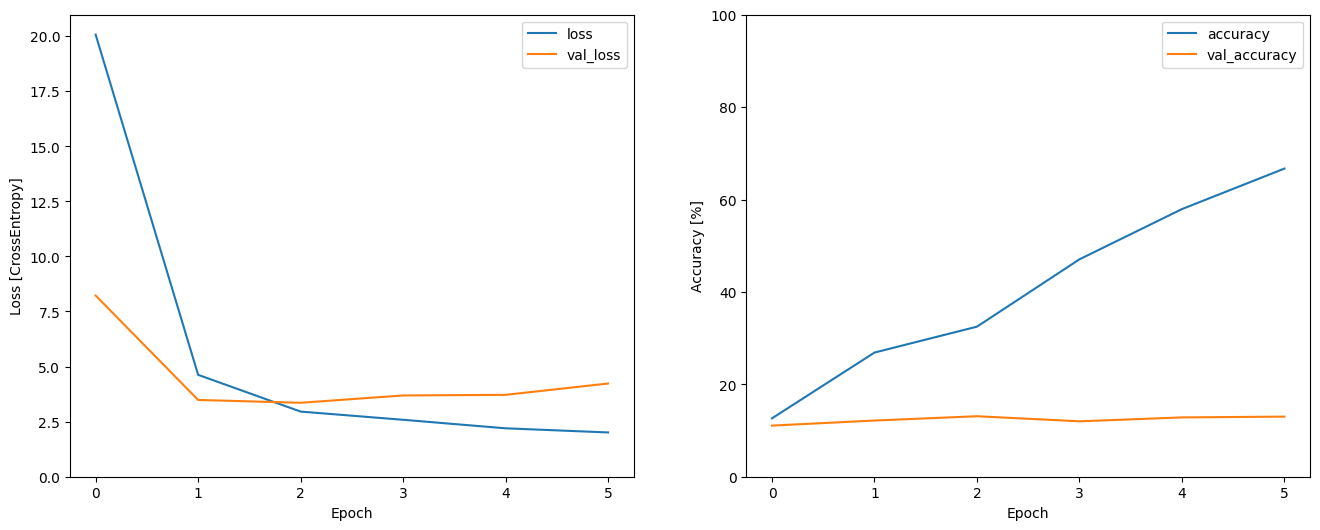

In [17]:
metrics = fit_data.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(fit_data.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(fit_data.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Final Results of Model 1

After tuning hyperparameters such as dropout rates, adding regularizers, varying layer size, and changing activation functions, the model stopped early due to overfitting and I was not able to get the models performance to improve. I tried specifically adressing the overfitting problem with regularizers and dropout, however the training performance suffered with no benifit to validation performance. I thought the model would be able to learn to classify sound waves from their envelopes but it seems like there are still too many similarities for it to generalize these envelope patterns to distinct words. I assume it is because the model only gains information about the intensity and duration of the signal but doesnt have enough information to learn about the frequencies that make up the signal. I thought maybe the change in magnitude at each sample would give the model enough insight into the frequency differences of each signal but it seems that the model needs more information to resolve underlying patterns.

## 4. Model 2: Magnitude Spectrum Model

### 4.1 Preproccessing the Data

I am using the fast fourier transform to generate the magnitude spectrum of each sound wave which gives the intensity of each frequency that make up the wave

In [18]:
def FFT(audio, label):
    tf.signal.fft(tf.complex(audio, 0.0))
    return audio, label

I then map the function to each data point in the set

In [19]:
train_fft = train_ds.map(FFT, tf.data.AUTOTUNE)
val_fft = val_ds.map(FFT, tf.data.AUTOTUNE)
test_fft = test_ds.map(FFT, tf.data.AUTOTUNE)

We can visualize the magnitude spectrum of a subset of samples in the dataset

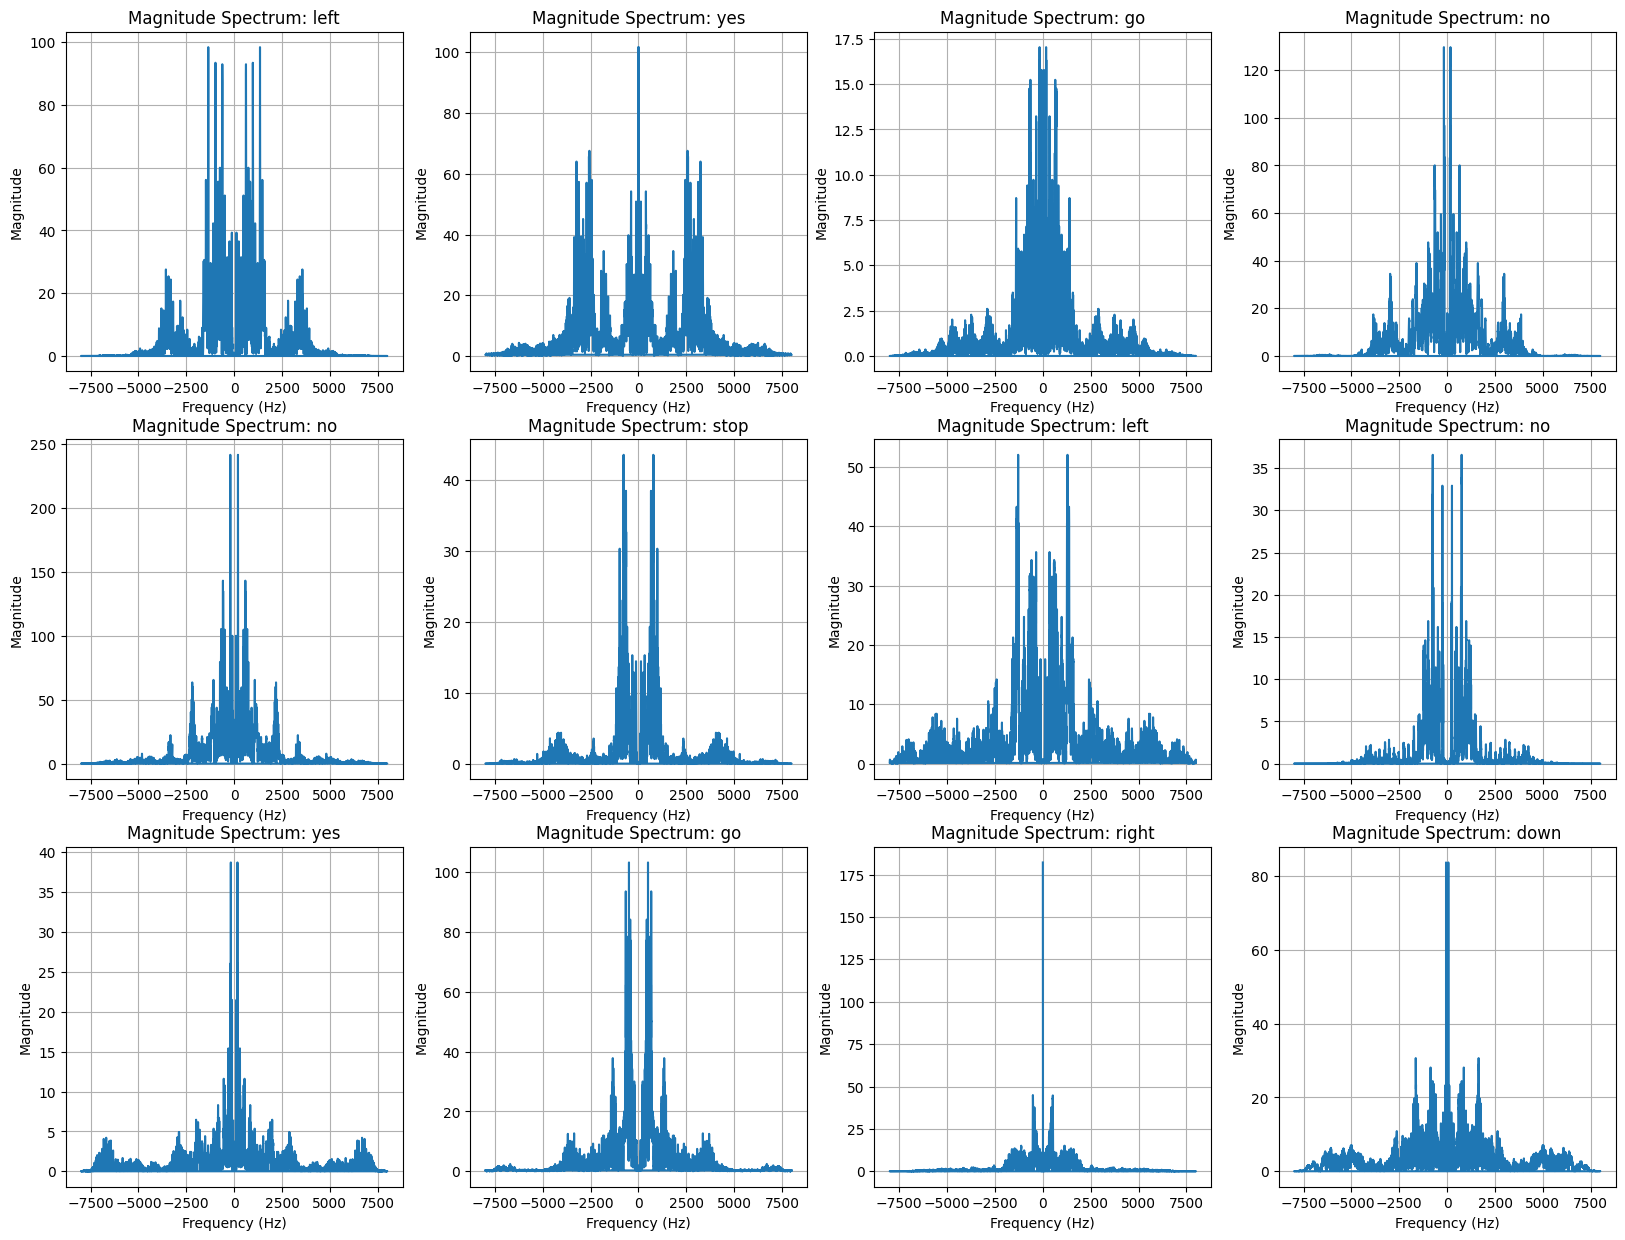

In [20]:
for example_audio, example_labels in train_fft.take(1):
    EXAMPLE_FFT = example_audio
    pass


m = 3 # Number of rows
n = 4 # Number of columns

# Create subplots
fig, axes = plt.subplots(m, n, figsize=(20, 15))

for i in range(n*m):
    # Apply FFT
    fft_output = tf.signal.fft(tf.complex(example_audio[i], 0.0))

    # Get frequency bins
    frequency_bins = np.fft.fftfreq(len(fft_output), 1 / SAMPLING_RATE)

    # Plot the spectrum (magnitude spectrum) in the corresponding subplot
    ax = axes[i // n, i % n]  # Calculate subplot index
    ax.plot(frequency_bins, np.abs(fft_output))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title(f'Magnitude Spectrum: {label_names[example_labels[i]]}')
    ax.grid(True)

### 4.2 Building the Model

I am using another dense nueral network to try and find the underlying pattern between a word and its magnitude spectrum

#### Loading the Data

Adding cache and prefetch operations to the datasets reduces read latency when pulling data to feed to the models

In [21]:
train_fft = train_fft.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_fft = test_fft.cache().prefetch(tf.data.AUTOTUNE)
val_fft = val_fft.cache().prefetch(tf.data.AUTOTUNE)

#### Trial 1

In [22]:
input_shape = EXAMPLE_FFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_fft.map(lambda fft, labels: fft)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    norm_layer,
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(output_shape)
], name='FFT_Model_1')

model.summary()


Model: "FFT_Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 16000)          │        32,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     4,096,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,168,011 (15.90 MB)

 Trainable params: 4,136,010 (15.78 MB)

 Non-trainable params: 32,001 (125.01 KB)

In [23]:
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
epochs = 20

fit_data = model.fit(
    train_fft,
    validation_data=val_fft,
    epochs=epochs,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.1170 - loss: 2.3700 - val_accuracy: 0.1199 - val_loss: 2.0977
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2051 - loss: 2.0506 - val_accuracy: 0.1166 - val_loss: 2.1252
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.2494 - loss: 2.0195 - val_accuracy: 0.1090 - val_loss: 2.1097
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2790 - loss: 1.9176 - val_accuracy: 0.1267 - val_loss: 2.1679
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.3373 - loss: 1.8486 - val_accuracy: 0.1427 - val_loss: 2.1740
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.3916 - loss: 1.7047 - val_accuracy: 0.1470 - val_loss: 2.3245
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4481 - loss: 1.6226 - val_accuracy: 0.1453 - val_loss: 2.3442
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4975 - loss: 1.4925 - val_accuracy: 0.1250 - v

#### Trial 1 Results

Text(0, 0.5, 'Accuracy [%]')

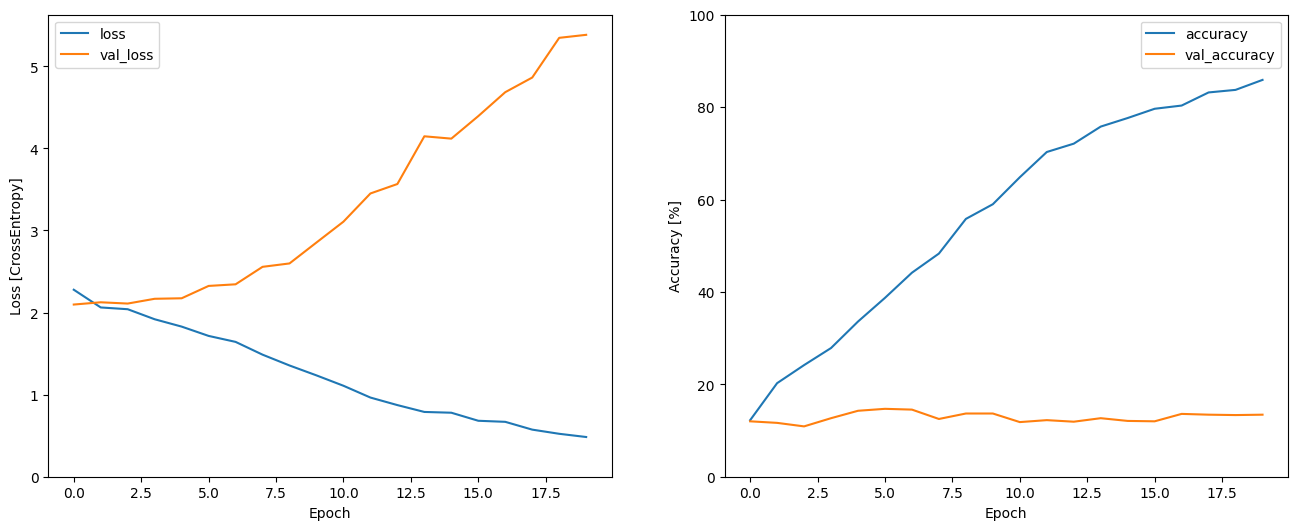

In [25]:
metrics = fit_data.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(fit_data.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(fit_data.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Trial 1 Discussion

Similar to the first model, the model using the FFT data performed incredibly poorly and seemed to have the same results as the first model where it can learn the training data but is guessing on validation data. The validation loss increased nearly 3 fold over the course of training. Even though words that were classified the same looked like they differed significantly from one another upon first inspection, I would have assumed that the magnitude spectrum of words in the same class would have underlying similarities.

#### Further Tuning

In [26]:
input_shape = EXAMPLE_FFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_fft.map(lambda fft, labels: fft)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    norm_layer,
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    layers.Dropout(0.3),
    layers.Dense(50, activation='sigmoid', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.5),
    layers.Dense(output_shape)
], name='FFT_Model_2')

model.summary()


model.compile(
    optimizer=optimizers.Nadam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 20

fit_data = model.fit(
    train_fft,
    validation_data=val_fft,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), # Comment out for testing and analysis
)

Model: "FFT_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 16000)          │        32,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     4,096,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,168,011 (15.90 MB)

 Trainable params: 4,136,010 (15.78 MB)

 Non-trainable params: 32,001 (125.01 KB)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.1325 - loss: 19.0470 - val_accuracy: 0.1258 - val_loss: 5.7122
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1464 - loss: 4.1346 - val_accuracy: 0.1233 - val_loss: 2.3461
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.1366 - loss: 2.3997 - val_accuracy: 0.1182 - val_loss: 2.1901
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.1408 - loss: 2.2763 - val_accuracy: 0.1225 - val_loss: 2.1461
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1297 - loss: 2.2077 - val_accuracy: 0.1174 - val_loss: 2.1375
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1294 - loss: 2.1981 - val_accuracy: 0.1191 - val_loss: 2.1346
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1445 - loss: 2.1578 - val_accuracy: 0.1233 - val_loss: 2.1440
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1680 - loss: 2.1315 - val_accuracy: 0.1309 - 

#### Further Tuning Results

Text(0, 0.5, 'Accuracy [%]')

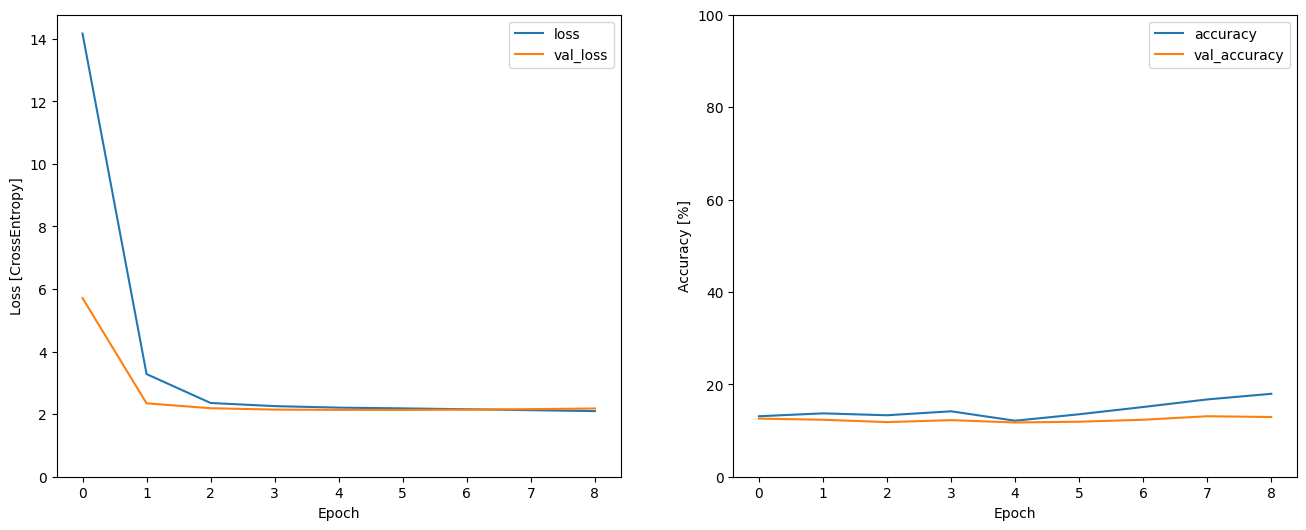

In [27]:
metrics = fit_data.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(fit_data.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(fit_data.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Final Discussion of Model 2

After further tweaking of hyperparameters such as layer size, activation function, adding l1 and l2 regularization, and dropout rates, I have not been able to increase the performance of the model. The model seems to suffer from overfitting early on and only leans the intricate relationship of the training data that cannot be applied to unseen data. By specifically adding regularizers and dropout layers to combat the overfitting issue, it can be seen that adding these only caused the training to suffer without benefiting validation accuracy. My guess is that eliminating the time aspect of the sound waves oversimplifies its data representation too much. Spoken words are a complex series of different pitches at different intensities and duration, I think reducing the data representation of these waves to 2 dimensions looses too much information about the unique patterns that make up spoken language. 

## 5. Model 3: Spectrogram Model

### 5.1 Preprocessing the Data

In order to preserve time, frequncy, and intensity information of a wav file, a short time fourier transform, or STFT, can be applied. 

In [28]:
def get_spectrogram(waveform, labels):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram, labels

The STFT function is then applied to the whole dataset

In [29]:
train_stft = train_ds.map(get_spectrogram, tf.data.AUTOTUNE)
val_stft = val_ds.map(get_spectrogram, tf.data.AUTOTUNE)
test_stft = test_ds.map(get_spectrogram, tf.data.AUTOTUNE)

In [30]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


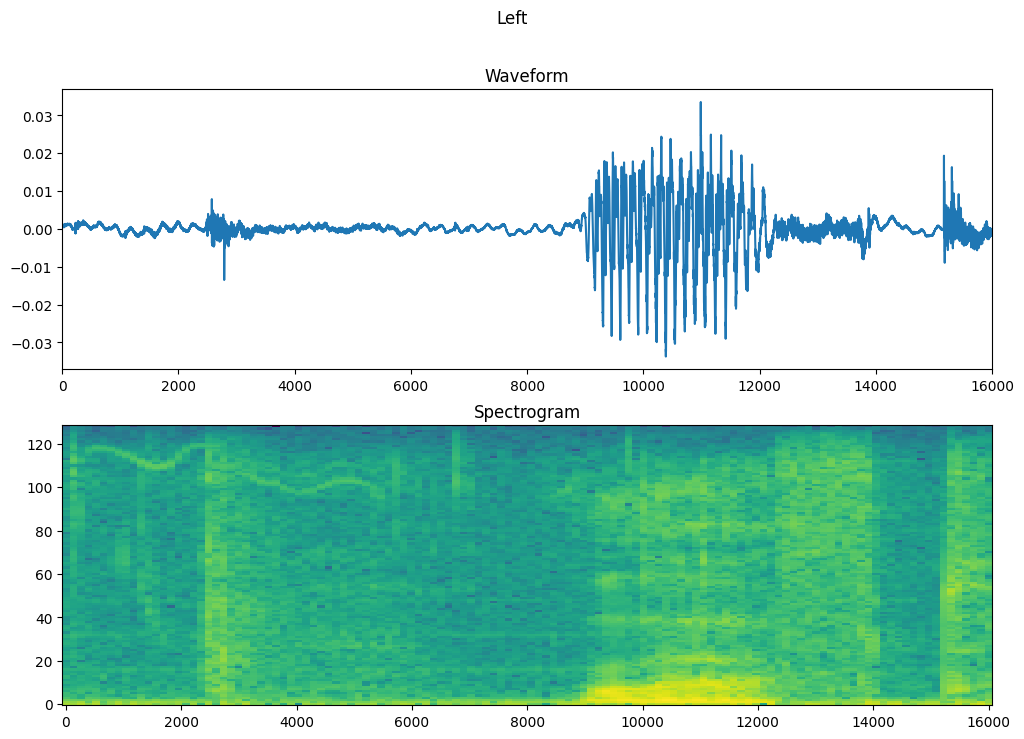

In [31]:
for example_audio, example_labels in train_ds.take(1):
  pass

label = label_names[example_labels[0]]
waveform = example_audio[0]
spectrogram, _ = get_spectrogram(waveform, _)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=SAMPLING_RATE))

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


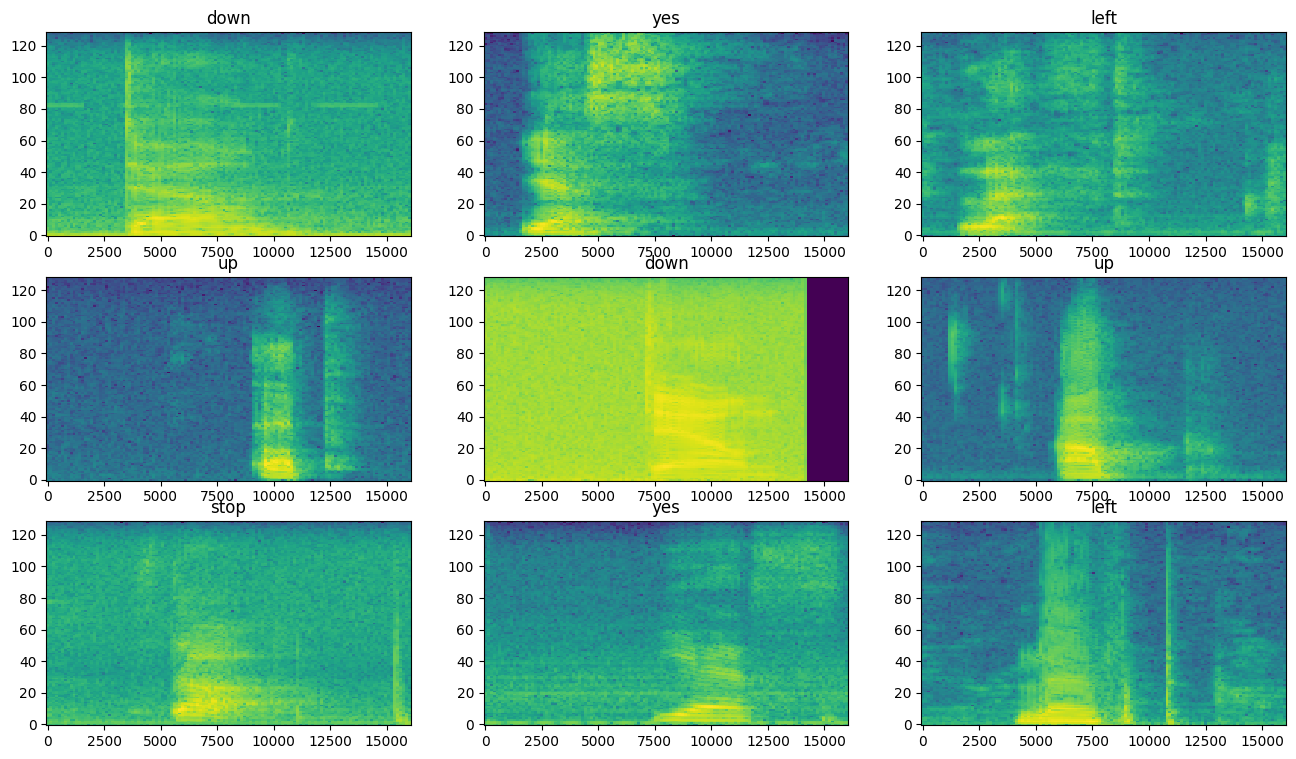

In [32]:
for example_spectrograms, example_spect_labels in train_stft.take(1):
    EXAMPLE_STFT = example_spectrograms
    pass

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

The purple blocks in the spectrogram represents the padding in the shorter clips. The spectrograms that seem to be more green are louder audio clips

### 5.2 Building the Model

A convolutional neural network was chosen to build the model for the spectrogram data because it is the best for learning patterns within 3 dimensional data structures and the spectrogram is a 3 dimensional representation of a sound wave 

#### Loading the Data

Adding cache and prefetch operations to the datasets reduces read latency when pulling data to feed to the models

In [33]:
train_stft = train_stft.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_fft = test_fft.cache().prefetch(tf.data.AUTOTUNE)
val_stft = val_stft.cache().prefetch(tf.data.AUTOTUNE)

#### Trial 1

In [34]:
input_shape = EXAMPLE_STFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_stft.map(lambda spec, labels: spec)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(128, 2, activation='relu'),
    layers.Conv2D(32, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(output_shape),
], name='STFT_Model_1')

model.summary()

Model: "STFT_Model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 31, 31, 128)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       921,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,819 (3.59 MB)

 Trainable params: 939,816 (3.59 MB)

 Non-trainable params: 3 (16.00 B)

In [35]:
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [36]:
epochs = 15

fit_data = model.fit(
    train_stft,
    validation_data=val_stft,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), # Comment out for testing and analysis
)

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.2669 - loss: 1.9466 - val_accuracy: 0.5076 - val_loss: 1.4576
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.4941 - loss: 1.4039 - val_accuracy: 0.6326 - val_loss: 1.1196
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.6058 - loss: 1.0775 - val_accuracy: 0.7280 - val_loss: 0.8729
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.7064 - loss: 0.8357 - val_accuracy: 0.7576 - val_loss: 0.7987
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7352 - loss: 0.7358 - val_accuracy: 0.7635 - val_loss: 0.7069
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.7764 - loss: 0.6333 - val_accuracy: 0.7922 - val_loss: 0.6639
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8052 - loss: 0.5441 - val_accuracy: 0.8108 - val_loss: 0.6275
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8300 - loss: 0.4794 - val_accuracy: 0.8049 - v

#### Trial 1 Results

Text(0, 0.5, 'Accuracy [%]')

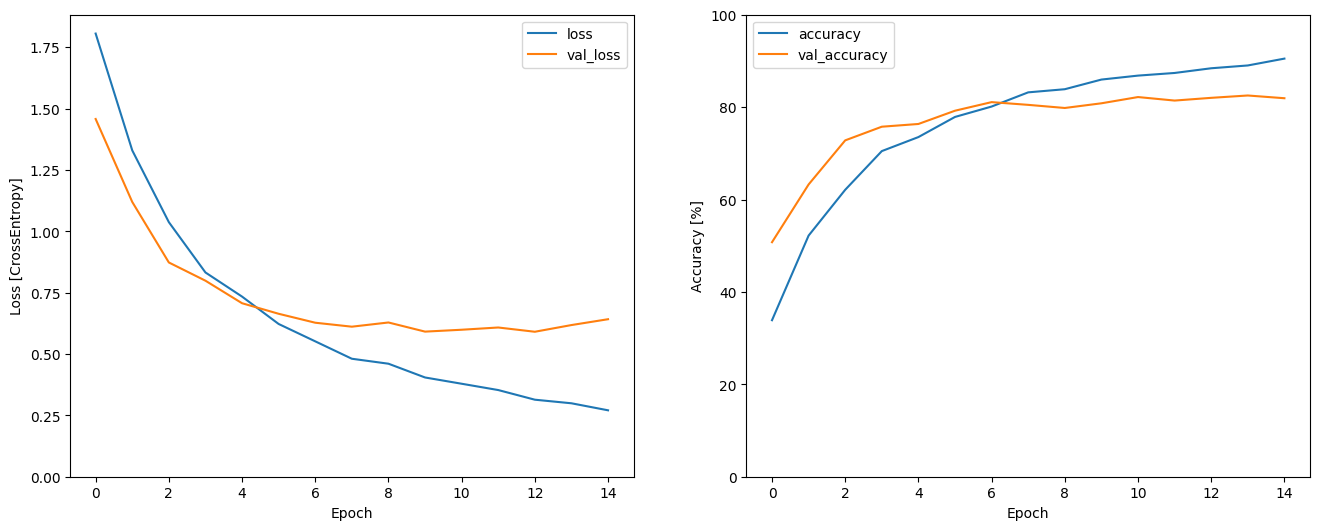

In [37]:
metrics = fit_data.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(fit_data.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(fit_data.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Trial 1 Discussion

My first time training the model, I didn't think the resizing layer was necessary and I though maybe the accuracy would improve without it but the model took too long to compile. A resizing layer was needed to perform hyperparameter tuning and proper analysis in a feesible amount of time. After adding the resizing layer and training the model, the model performed pretty well, endeding with a training accuracy of 91.71% and a validation accuracy of 81.84%. It seems like the model is suffering from overfitting which can be reduced by adding or tuning dropout layers, changing the complexity of the model, or adding some regularization. 

#### Further Tuning

In [52]:
input_shape = EXAMPLE_STFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_stft.map(lambda spec, labels: spec)) # Uses the STFT data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.0001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.35),
    layers.Dense(output_shape),
], name='STFT_Model_2')

model.summary()

model.compile(
    optimizer=optimizers.Nadam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 30

fit_data = model.fit(
    train_stft,
    validation_data=val_stft,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4), # Comment out for testing and analysis
)

Model: "STFT_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_7 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,595 (1.31 MB)

 Trainable params: 343,592 (1.31 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.1467 - loss: 2.5414 - val_accuracy: 0.3421 - val_loss: 2.1276
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.3203 - loss: 2.0882 - val_accuracy: 0.5169 - val_loss: 1.5485
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.4658 - loss: 1.6685 - val_accuracy: 0.6427 - val_loss: 1.2313
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.5767 - loss: 1.3753 - val_accuracy: 0.7196 - val_loss: 1.0630
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.6341 - loss: 1.2074 - val_accuracy: 0.7432 - val_loss: 0.9998
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.6821 - loss: 1.1033 - val_accuracy: 0.7644 - val_loss: 0.9243
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.7115 - loss: 1.0085 - val_accuracy: 0.7838 - val_loss: 0.8657
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.7249 - loss: 1.0011 - val_accu

#### Further Tuning Results

Text(0, 0.5, 'Accuracy [%]')

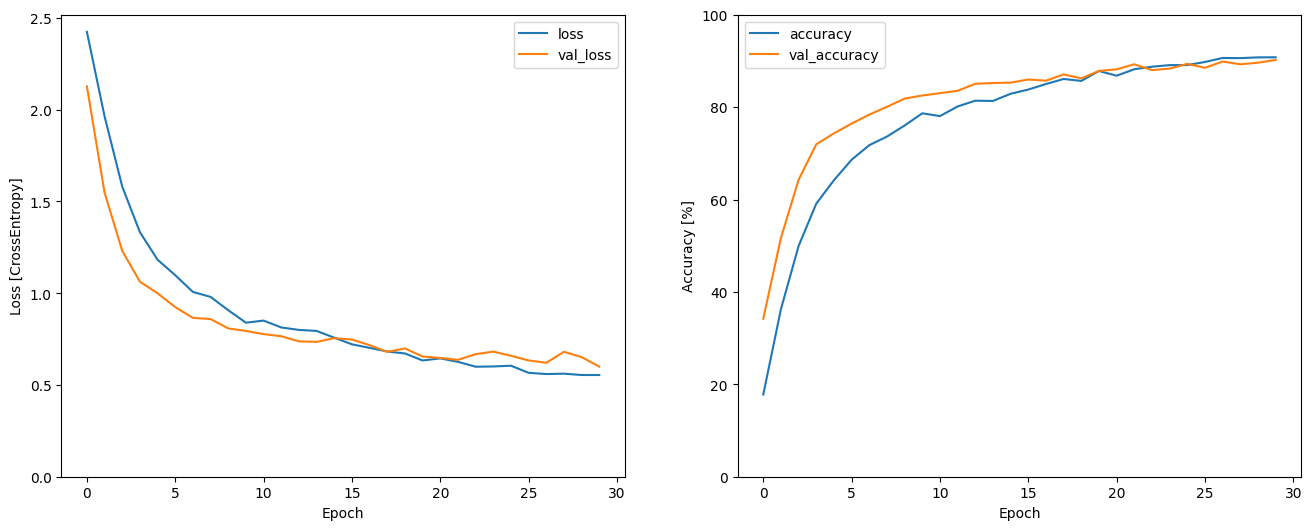

In [53]:
metrics = fit_data.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(fit_data.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(fit_data.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [54]:
best_model = model

#### Final Tuning Discussion

The best changes I made were adding a second dropout layer, adding upsampling before the max pooling layer, and changing the size of the layers and kernels. Adding another dense layer also seemed to improve accuracy with validation accuracy reaching 83.19%. I tried adding two more convolutional layers, 16 and 32 neurons, along with a maxpooling layer and it seemed to decrease the accuracy by a significant margin which I was a little surprised about, I guess it downsampled the data too much where it lost some important features. Doubling the neuron count in all the convolution layers and letting the model run for a little longer, I was able to increase the validation accuracy to 88.51% with a training accuracy of 90.12% which means there isnt much overfitting. I noticed that the loss of the model started relatively high so I tried adding glorot normal kernel initializers to the convolutional and dense layers but it seemed to have little or no affect, with losses during testing before and after adding the initializers starting at around 2. I also tried editing the kernel size of the maxpooling layer, increasing it to 3x3, but it only had negative effects on the models performance. I also changed the optimizer from Adam to Nadam hopping it would help the model converge to a minimum loss faster and it seems to have a slight improvment on the models performance. The last changes I made was adding one more dropout layer before the output layer and set it to a .35 dropout rate, added an l1 regularizer to the first dense layer, and let the model run for a little longer while giving it a little more patience to try and maximize the models performance as much as possible. With these changes I was able to reach a traing accuracy and loss of 90.02% and 0.5671 as well as a valadation accuracy and loss of 90.20% and 0.6001 after 30 epochs, which is 10% higher than the base model. 

#### Global Max Pooling

I researched global max pooling and decided to test out its affects on CNN architecture and decided to implement it into my own architure. 

In [40]:
input_shape = EXAMPLE_STFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_stft.map(lambda spec, labels: spec)) # Uses the STFT data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Dropout(0.5),
    layers.Conv2D(8, 3, activation='relu', kernel_regularizer=regularizers.l1(0.0001)),
    layers.GlobalMaxPooling2D(),
    layers.Dense(output_shape),
], name='STFT_Model_3')

model.summary()

model.compile(
    optimizer=optimizers.Nadam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 30

fit_data = model.fit(
    train_stft,
    validation_data=val_stft,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4), # Comment out for testing and analysis
)

Model: "STFT_Model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_6 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 8)        │         4,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 8)              │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,579 (525.70 KB)

 Trainable params: 134,576 (525.69 KB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.1929 - loss: 2.0546 - val_accuracy: 0.3944 - val_loss: 1.7982
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.4139 - loss: 1.6780 - val_accuracy: 0.5861 - val_loss: 1.2761
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.5575 - loss: 1.2991 - val_accuracy: 0.6613 - val_loss: 0.9970
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.6394 - loss: 1.0289 - val_accuracy: 0.7204 - val_loss: 0.8397
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.7078 - loss: 0.8532 - val_accuracy: 0.7720 - val_loss: 0.7339
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.7297 - loss: 0.7561 - val_accuracy: 0.7787 - val_loss: 0.6749
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - accuracy: 0.7472 - loss: 0.6847 - val_accuracy: 0.8015 - val_loss: 0.6115
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.7738 - loss: 0.6487 - val_accu

Text(0, 0.5, 'Accuracy [%]')

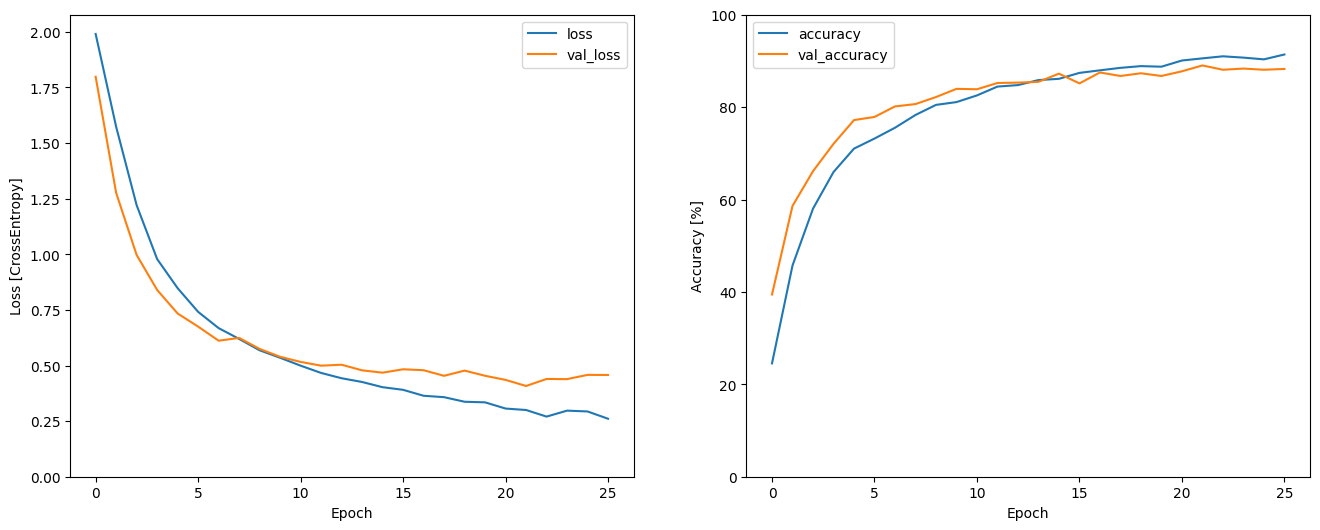

In [42]:
metrics = fit_data.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(fit_data.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(fit_data.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Discussion

Global max pooling is supposed to replace fully connected layers in a CNN by taking the average of the inputs of each layer in the previous convolutional layer. The theory behind this layer is that the previous layer is supposed to hold feature data specific to each one of the classes in its previous layer and by taking the global max of each layer and passing it to a one dimensional vector, each value in the vector represents the sum of the features that distinguish each class in the dataset. After tuning, the max pooling strategy performed almost on par with the previous architecture on average after tuning but sold short in the later epochs. It ended with an average validation accuracy of 88.26% and loss of .4574 which was slightly less than the previously tuned model.

#### Model 3 Final Discussion

The retuned model and globa max pooling model performed much better than the original but the tuned model ended up performing better after testing. Adding dropout and model complexity helped the model learn underlying patterns much better than the base. Adding l1 and l2 regularizing helped keep the model from overfitting but also made it take much longer to converge. Overall, increasing the model complexity and adding regularization and dropout to handle overfitting by the model greatly increased the abilty for the model to learn the generalized patterns within the numerical representaions of human language. 

## 5. Evaluating performance

The spectrogram model had the best results during training so it will be used for further evaluation

### 5.1 Testing model on the test data

In [63]:
best_model.evaluate(test_stft, return_dict=True)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8970 - loss: 0.6028


{'accuracy': 0.8972039222717285, 'loss': 0.6170632243156433}

~90% accuracy on classification is incredibly good performnce considering the amount of noise in alot of the input data which was purposely added to make the model robust

### 5.2 Displaying the Confusion Matrix

In [64]:
y_pred = best_model.predict(test_stft)

y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_stft.map(lambda s,lab: lab)), axis=0)

 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


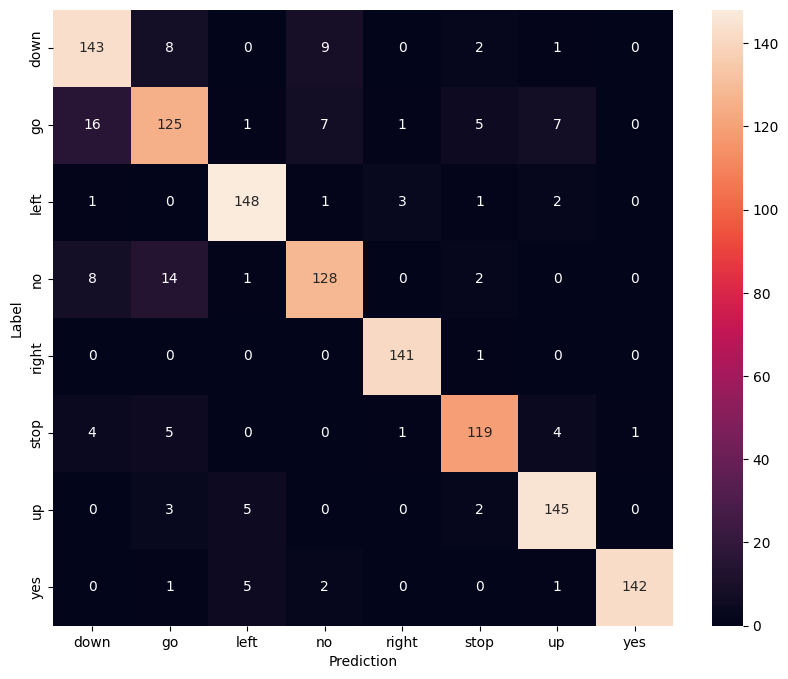

In [65]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

"Go" and "No" seem to be the hardest words for the model to accurately predict as seen by the number of misclassifications for those particular words

### 5.3 Running Inference on an audio file

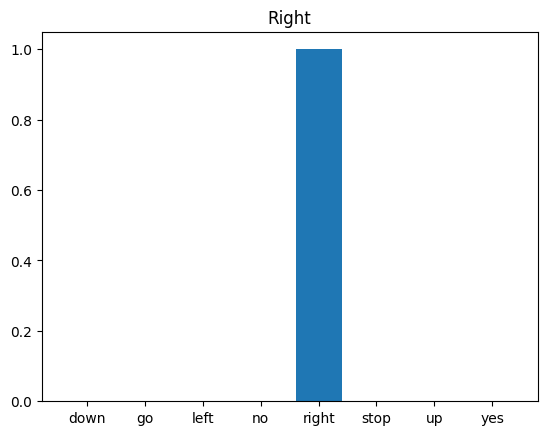

In [66]:
x = data_dir/'right/fce65496_nohash_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLING_RATE,)
x = tf.squeeze(x, axis=-1)
waveform = x
x, _ = get_spectrogram(x, _)
x = x[tf.newaxis,...]

prediction = best_model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Right')
plt.show()

display.display(display.Audio(waveform, rate=16000))

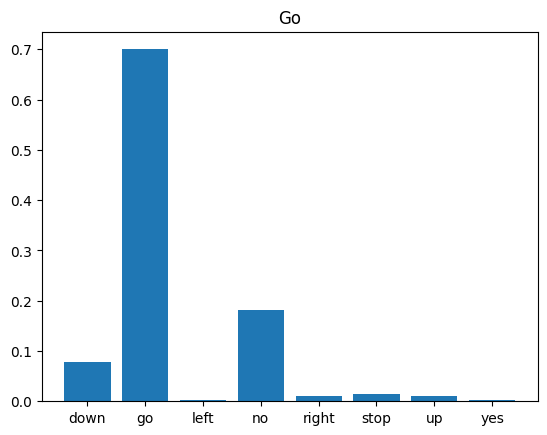

In [67]:
x = data_dir/'go/0d53e045_nohash_0.wav'  #'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLING_RATE,)
x = tf.squeeze(x, axis=-1)
waveform = x
x, _ = get_spectrogram(x, _)
x = x[tf.newaxis,...]

prediction = best_model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Go')
plt.show()

display.display(display.Audio(waveform, rate=16000))

This shows the difference in uncertainty the model has with the words "Right", which the model nearly got 100% of classifications for right according to the confusion matrix, and "Go", which the model missclasified quite a bit.

### 5.4 Exporting the model

In [68]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x, _ = get_spectrogram(x, None)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [69]:
'''
# Commented out to avoid overwriting saved model
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))
tf.saved_model.save(export, "saved")
'''


'\n# Commented out to avoid overwriting saved model\nexport = ExportModel(model)\nexport(tf.constant(str(data_dir/\'no/01bb6a2a_nohash_0.wav\')))\ntf.saved_model.save(export, "saved")\n'

In [70]:
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-0.20653437,  3.4121723 , -3.0402675 ,  1.3952847 , -1.7674203 ,
         -1.1576552 ,  0.4123078 , -3.451845  ]], dtype=float32)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'go'], dtype=object)>}